In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
#from nltk.stem import LancasterStemmer,WordNetLemmatizer

from bs4 import BeautifulSoup
import re,string,unicodedata, copy
import random

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)


# Load Dataset

In [2]:
imdb_data=pd.read_csv('IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


# Text Preprocessing

### Denoising the text:
remove HTML tags, square brackets, punctuations and special characters.

### Remove Stopwords:
remove words which do not add useful information to the classifier.

In [4]:
#Removing all the noise
def denoise_text(text):
    #remove html strips
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    #remove square brackets
    text = re.sub('\[[^]]*\]', '', text)
    #replace punctuation with space
    text = re.sub(r'[,.;@#?!&$\-]+\ *', ' ', text, flags=re.VERBOSE)
    #remove special characters
    text=re.sub(r'[^a-zA-z0-9\s]', '', text)
    return text.lower()

imdb_data['review']=imdb_data['review'].apply(denoise_text)

In [5]:
print('Sample Text after denoising:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after denoising:


'a wonderful little production the filming technique is very unassuming very old time bbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great masters of comedy and his life the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwells murals decorating every surface are terribly well done '

In [6]:
#text tokenizer
tokenizer=ToktokTokenizer()

#get list of stopwords
stop=set([re.sub(r'[^a-zA-z0-9\s]', '', st) for st in stopwords.words('english')])

#removing the stopwords
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stop]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

In [7]:
print('Sample Text after filtering:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after filtering:


'wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great masters comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwells murals decorating every surface terribly well done'

In [8]:
'''Additional preprocessing'''
#stem the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

In [9]:
print('Sample Text after stemming:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after stemming:


'wonder littl product film techniqu unassum old time bbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrificli written perform piec master product one great master comedi life realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particularli scene concern orton halliwel set particularli flat halliwel mural decor everi surfac terribl well done'

In [10]:
imdb_data['sentiment'] = imdb_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [11]:
train_imdb, test_imdb = train_test_split(imdb_data,test_size = 0.3)
x_train,y_train,x_test,y_test = train_imdb['review'].values,train_imdb['sentiment'].values,test_imdb['review'].values,test_imdb['sentiment'].values
print(f'Train data has {x_train.shape[0]} samples')
print(f'Test data has {x_test.shape[0]} samples')

Train data has 35000 samples
Test data has 15000 samples


# Exploratory Data Analysis

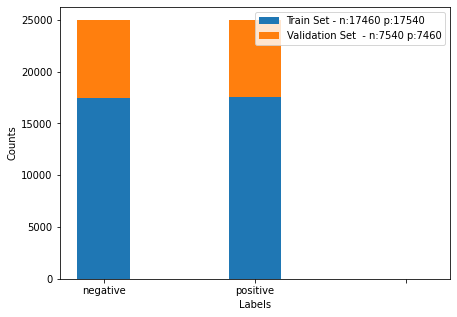

In [12]:
train = (pd.DataFrame(data = y_train).value_counts()[0],pd.DataFrame(data = y_train).value_counts()[1], 0)
valid = (pd.DataFrame(data = y_test).value_counts()[0],pd.DataFrame(data = y_test).value_counts()[1],0)

ind = np.arange(3)
width = 0.35

fig = plt.subplots(figsize=(7,5))
p1 = plt.bar(ind, train, width)
p2 = plt.bar(ind, valid, width, bottom=train)

plt.ylabel('Counts')
plt.xlabel('Labels')
plt.xticks(ind, ('negative','positive', None))
plt.legend((p1[0],p2[0]),('Train Set - n:'+str(train[0])+' p:'+str(train[1]), 'Validation Set  - n:'+str(valid[0])+' p:'+str(valid[1])), loc = 'upper right')
plt.show()

C:\Users\sayan\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Review Lengths positive reviews


count    17540.000000
mean       121.654561
std         94.503085
min          6.000000
25%         63.000000
50%         89.000000
75%        149.000000
max       1433.000000
Name: review, dtype: float64

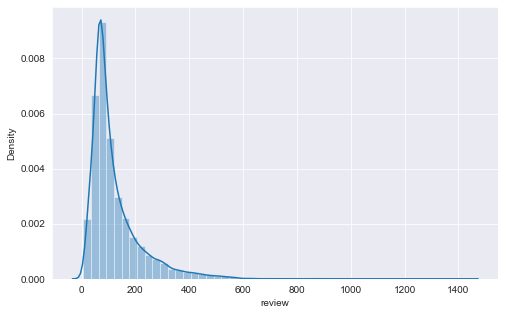

In [13]:
seqlen = train_imdb['review'][train_imdb['sentiment']==1].apply(lambda x: len(x.split()))
sns.set_style('darkgrid')
plt.figure(figsize = (8, 5))
seqlen_plot = sns.distplot(seqlen)

print('Review Lengths positive reviews')
seqlen.describe()

Review Lengths negative reviews


C:\Users\sayan\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    17460.000000
mean       118.277778
std         85.691374
min          4.000000
25%         65.000000
50%         90.000000
75%        144.000000
max        716.000000
Name: review, dtype: float64

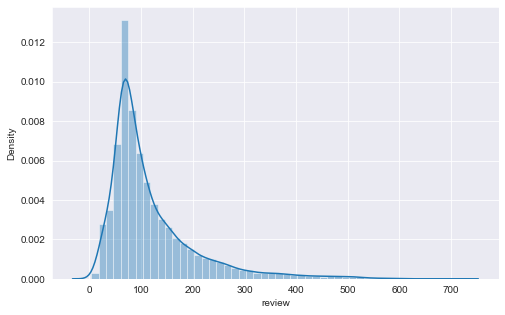

In [14]:
seqlen = train_imdb['review'][train_imdb['sentiment']==0].apply(lambda x: len(x.split()))
sns.set_style('darkgrid')
plt.figure(figsize = (8, 5))
seqlen_plot = sns.distplot(seqlen)

print('Review Lengths negative reviews')
seqlen.describe()

<function matplotlib.pyplot.show(close=None, block=None)>

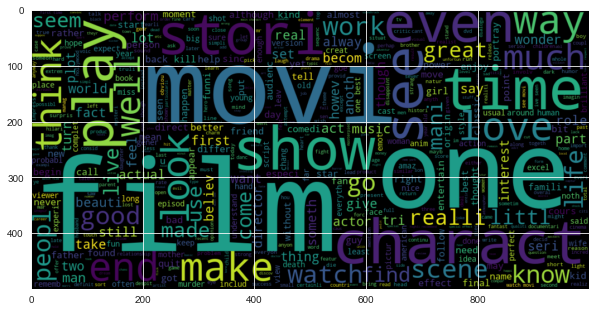

In [15]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=' '.join(train_imdb[train_imdb['sentiment']==1].review.tolist())
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

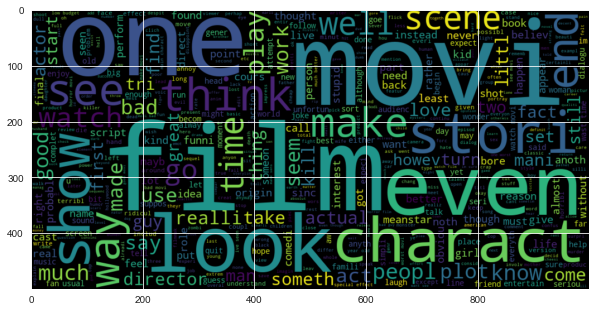

In [16]:
#word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=' '.join(train_imdb[train_imdb['sentiment']==0].review.tolist())
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

In [17]:
#convert training and test to tfidf vectors
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train1 = vectorizer.transform(x_train)
x_test1 = vectorizer.transform(x_test)

In [18]:
word_list = []

for sent in x_train:
    for word in sent.split():
        if word != '':
            word_list.append(word)

#make vocab dictionary
corpus = Counter(word_list)
corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:5000]

#transform courpus to tfidf vector
vocabvec = vectorizer.transform(np.array(corpus_))

In [19]:
print(f'Length of vocabulary is {len(corpus_)}')

Length of vocabulary is 5000


In [20]:
# naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import normalize

In [21]:
clf = MultinomialNB()
clf.fit(x_train1, y_train)
print(f'Naive Bayes model accuracy: {clf.score(x_test1, y_test)*100}%')

Naive Bayes model accuracy: 86.26666666666667%


In [22]:
y_pred = clf.predict(x_test1)
conf_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'class 0 (specificity): 0.873 | class 1 (sensitivity): 0.853')

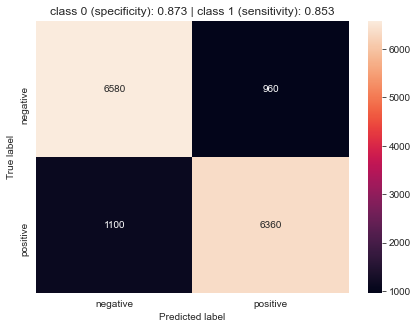

In [23]:
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))
df_cm = pd.DataFrame(conf_matrix, index = [i for i in ['negative','positive']],
                  columns = [i for i in ['negative','positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}'.format(accs[0],accs[1]))

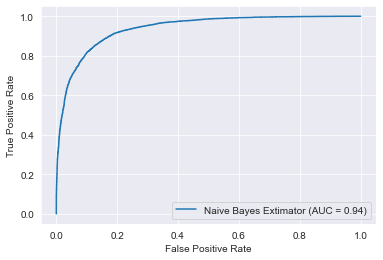

In [24]:
y_proba = clf.predict_proba(x_test1)
fpr, tpr, thrs = metrics.roc_curve(y_test, y_proba[:,1])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'Naive Bayes Extimator')
display1.plot()
plt.show()

In [25]:
#vectorize text
def predict_text(text):
    inputs = vectorizer.transform(np.array([text]))
    return clf.predict_proba(inputs)[0][1]

sentiment_dict = {1:'positive', 0:'negtive'}

In [26]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

see driven plane flight america 3 year ago truli believ seen worst film ever creat could relax safe knowledg would never suffer much front screen ever unfortun found last night case revolv monstrous bad actual think recommend friend go see feel like im one stupid enough con watch realli quit amaz much film fall complet face constant mean constant voic over main charact total inan pretenti nonsens actual get angri cinema listen andr benjamin utterli relentless drone seem like half film whilst time think would turkish done complet joke gangstercon man whatev he suppos made offer ill tell would told fk blown head away watch utter disdain equal inept partner waddl away fast chubbi littl leg would carri mean suppos believ go jake head offer solut problem theyr con men therefor must obvious also skill cure incur blood diseas mean ff start wonder symptom get wors penni drop third day happen instead richi subject audienc pain patronis phone call avi jake let know he con anyway add small posit 

In [27]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

cheap mind blisteringli dull stori act singl good line even line bad enough good memor deliveri even blooper reel includ dvd show inept actor littl fun esoter occult basi apathet inauthent antagonist fail creepi believ homoerot overton pointlessli tame dissatisfi limit young boy caress chest flaccid boxer im gay enough appreci littl action might least kept girlfriend awak
Actual sentiment is  : negtive
Predicted sentiment is negative with a probability of 0.8402686567252968


# synthetic data prep and evaluating

In [30]:
#generate probabilities of a word in corpus being neg or pos
proba = clf.predict_proba(vocabvec)

In [31]:
from collections import defaultdict
pos_vocab = defaultdict(list)

for i, w in enumerate(corpus_):
    pos_vocab[w] = proba[i][1] 

neg_vocab = defaultdict(list)

for i, w in enumerate(corpus_):
    neg_vocab[w] = proba[i][0] 

In [32]:
rev_len_pd = pd.Series([len(i.split()) for i in x_train])
num_reviews = 5000
num_words_per_review = list(rev_len_pd.sample(num_reviews))
pos_reviews = []
pos = np.array(list(pos_vocab.values()))
pos_probs = pos / sum(pos)
pos_words = list(pos_vocab.keys())
t = time.time()
for i in range(num_reviews):
    pos_reviews += [' '.join(np.random.choice(pos_words, size=num_words_per_review[i], p=pos_probs))]
    if i % 500 == 0:
        print("Finished generating {} positive reviews in {:.2f} seconds".format(i,time.time() - t))
print("Finished Positive Reviews")

num_words_per_review = list(rev_len_pd.sample(num_reviews))
neg_reviews = []
neg = np.array(list(neg_vocab.values()))
neg_probs = neg / sum(neg)
neg_words = list(neg_vocab.keys())
t = time.time()
for i in range(num_reviews):
    neg_reviews += [' '.join(np.random.choice(neg_words, size=num_words_per_review[i], p=neg_probs))]
    if i % 500 == 0:
        print("Finished generating {} negative reviews in {:.2f} seconds".format(i,time.time() - t))

print("Finished Negative Reviews")

rev_list = pos_reviews + neg_reviews
sen_list = [1]*len(pos_reviews) + [0]*len(neg_reviews)

syn_data = pd.DataFrame([rev_list,sen_list], index=['review','sentiment']).T

syn_data.to_csv('generated_review.csv', index=False)

print(pd.Series([len(text.split()) for text in syn_data['review']]).describe())
#print(syn_data.review[0])

Finished generating 0 positive reviews in 0.00 seconds
Finished generating 500 positive reviews in 0.65 seconds
Finished generating 1000 positive reviews in 1.26 seconds
Finished generating 1500 positive reviews in 1.83 seconds
Finished generating 2000 positive reviews in 2.39 seconds
Finished generating 2500 positive reviews in 2.96 seconds
Finished generating 3000 positive reviews in 3.52 seconds
Finished generating 3500 positive reviews in 4.08 seconds
Finished generating 4000 positive reviews in 4.65 seconds
Finished generating 4500 positive reviews in 5.20 seconds
Finished Positive Reviews
Finished generating 0 negative reviews in 0.00 seconds
Finished generating 500 negative reviews in 0.57 seconds
Finished generating 1000 negative reviews in 1.15 seconds
Finished generating 1500 negative reviews in 1.72 seconds
Finished generating 2000 negative reviews in 2.28 seconds
Finished generating 2500 negative reviews in 2.83 seconds
Finished generating 3000 negative reviews in 3.40 seco

In [33]:
train_syn, test_syn = train_test_split(syn_data,test_size = 0.3)
x_train,y_train,x_test,y_test = train_syn['review'].values,train_syn['sentiment'].values,test_syn['review'].values,test_syn['sentiment'].values
print(f'Train data has {x_train.shape[0]} samples')
print(f'Test data has {x_test.shape[0]} samples')

Train data has 7000 samples
Test data has 3000 samples


# EDA

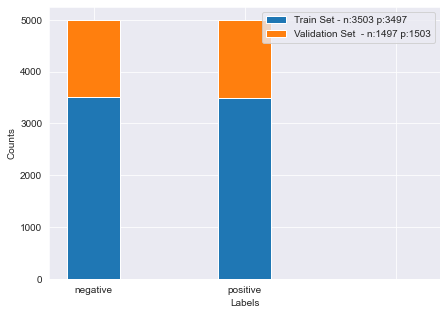

In [34]:
train = (pd.DataFrame(data = y_train).value_counts()[0],pd.DataFrame(data = y_train).value_counts()[1], 0)
valid = (pd.DataFrame(data = y_test).value_counts()[0],pd.DataFrame(data = y_test).value_counts()[1],0)

ind = np.arange(3)
width = 0.35

fig = plt.subplots(figsize=(7,5))
p1 = plt.bar(ind, train, width)
p2 = plt.bar(ind, valid, width, bottom=train)

plt.ylabel('Counts')
plt.xlabel('Labels')
plt.xticks(ind, ('negative','positive', None))
plt.legend((p1[0],p2[0]),('Train Set - n:'+str(train[0])+' p:'+str(train[1]), 'Validation Set  - n:'+str(valid[0])+' p:'+str(valid[1])), loc = 'upper right')
plt.show()

Review Lengths positive reviews


C:\Users\sayan\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    3497.000000
mean      116.740063
std        90.244143
min         5.000000
25%        63.000000
50%        87.000000
75%       139.000000
max      1101.000000
Name: review, dtype: float64

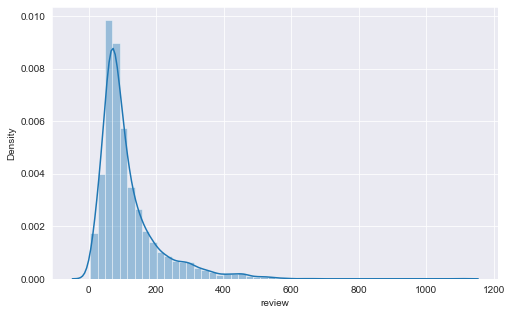

In [35]:
seqlen = train_syn['review'][train_syn['sentiment']==1].apply(lambda x: len(x.split()))
sns.set_style('darkgrid')
plt.figure(figsize = (8, 5))
seqlen_plot = sns.distplot(seqlen)

print('Review Lengths positive reviews')
seqlen.describe()

Review Lengths negative reviews


C:\Users\sayan\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    3503.000000
mean      122.370825
std        91.352052
min         9.000000
25%        65.000000
50%        92.000000
75%       150.000000
max       817.000000
Name: review, dtype: float64

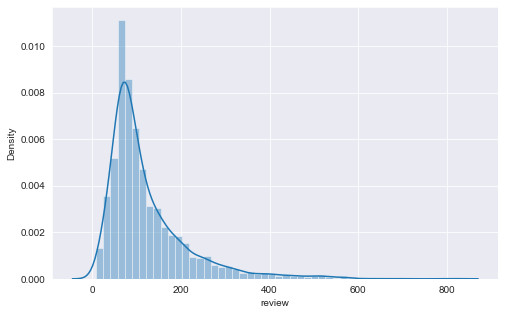

In [36]:
seqlen = train_syn['review'][train_syn['sentiment']==0].apply(lambda x: len(x.split()))
sns.set_style('darkgrid')
plt.figure(figsize = (8, 5))
seqlen_plot = sns.distplot(seqlen)

print('Review Lengths negative reviews')
seqlen.describe()

<function matplotlib.pyplot.show(close=None, block=None)>

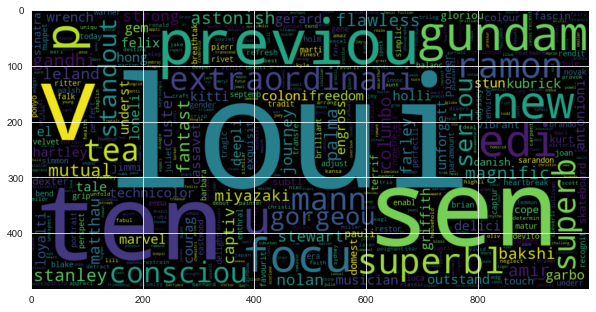

In [37]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=' '.join(train_syn[train_syn['sentiment']==1].review.tolist())
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

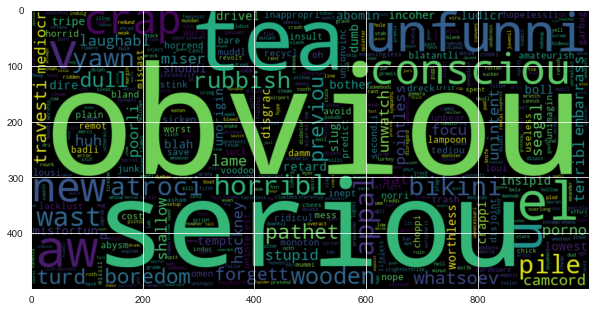

In [38]:
#word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=' '.join(train_syn[train_syn['sentiment']==0].review.tolist())
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

In [39]:
#convert training and test to tfidf vectors
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train1 = vectorizer.transform(x_train)
x_test1 = vectorizer.transform(x_test)
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

In [40]:
clf = MultinomialNB()
clf.fit(x_train1, y_train)
print(f'Naive Bayes model accuracy for synthetic dataset: {clf.score(x_test1, y_test)*100}%')

Naive Bayes model accuracy for synthetic dataset: 98.36666666666667%


In [41]:
y_pred = clf.predict(x_test1)
conf_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'class 0 (specificity): 0.981 | class 1 (sensitivity): 0.987')

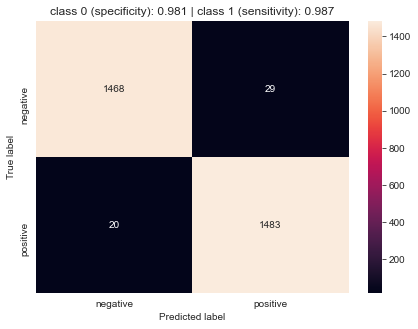

In [42]:
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))
df_cm = pd.DataFrame(conf_matrix, index = [i for i in ['negative','positive']],
                  columns = [i for i in ['negative','positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}'.format(accs[0],accs[1]))

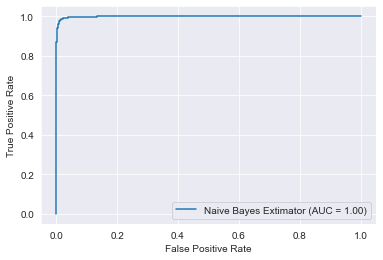

In [43]:
y_proba = clf.predict_proba(x_test1)
fpr, tpr, thrs = metrics.roc_curve(y_test, y_proba[:,1])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'Naive Bayes Extimator')
display1.plot()
plt.show()

In [46]:
index = random.randint(0, 3000)
print(test_syn['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_syn["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_syn['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

scientif respons gratuit ex plant inclus cemeteri bait useless industri go scare although ace wood samurai techniqu tech statement project buster convent franci urban iron confess bobbi beaten amor hitler latter insist killer jaw ha tacki invest emperor cross filmmak client occupi situat asleep program henc opposit simultan arm confid real heard pad remark undermin simpson terribl redneck mr proclaim physic moron move skip meaning dear swear consid previous dracula bottom witch churn immatur advertis heap mob step explan incompet hugh superhero snipe choic tension situat error wannab romero attack critiqu shop monk phenomenon 7 crack milk 4 comment garden dreck comput oliv norman land 2004 wow hunt section highest cancer lethal knock get horribl sadli
Actual sentiment is  : negtive
Predicted sentiment is negative with a probability of 0.8712801412412164


In [47]:
index = random.randint(0, 3000)
print(test_syn['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_syn["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_syn['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

wig hand inabl dreck avoid reliabl resembl brought poison illog blockbust valley fulfil feet better credibl player sold surreal loser long consist diamond rate hous countless pig creatur lie earli modern virtu comed ross box heroic nine overact gray overdon exagger wors shark ken treat sheer quietli tortur aforement properti 1982 psychic euro undeni spontan american dud estat resurrect noth jennif onlin needless trait opportun sole altern overr 4 convent confront bite attract onto irish king agent manag mortal utter mankind circu expedit retard doug real infam colin yell could wardrob broadway may opportun revers yell wander fort rick 2004 forgett anytim illeg egg attorney snake coat lover scotland cue etc cute conan stereotyp sen patient freak sinc pant annoy orient hot financi fell ago save unwatch norri amateurish amount someon hip hip shame ugli weird thru accident frog facil hotel point cute inform cast choic flaw jump articl restrict ice artsi goofi stroke belli tip bbc rocki gon

# evaluating model trained on synthetic data on real world test data

In [48]:
#replace synthetic test set with real world test set
x_test,y_test = test_imdb['review'].values,test_imdb['sentiment'].values
x_test1 = vectorizer.transform(x_test)
y_test = y_test.astype('int64')

In [49]:
print(f'Naive Bayes model accuracy: {clf.score(x_test1, y_test)*100}%')

Naive Bayes model accuracy: 80.78%


Text(0.5, 1.0, 'class 0 (specificity): 0.940 | class 1 (sensitivity): 0.675')

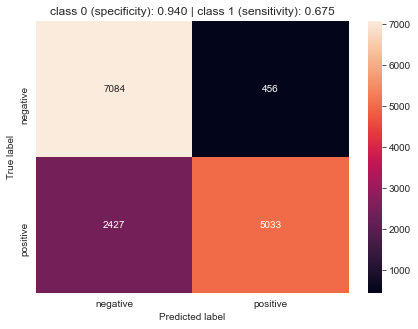

In [50]:
y_pred = clf.predict(x_test1)
conf_matrix = confusion_matrix(y_test, y_pred)
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))
df_cm = pd.DataFrame(conf_matrix, index = [i for i in ['negative','positive']],
                  columns = [i for i in ['negative','positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}'.format(accs[0],accs[1]))

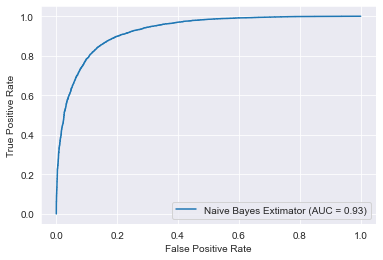

In [51]:
y_proba = clf.predict_proba(x_test1)
fpr, tpr, thrs = metrics.roc_curve(y_test, y_proba[:,1])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'Naive Bayes Extimator')
display1.plot()
plt.show()

In [52]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

said person film peter bogdonavitch base life chang thing around fit charact detect detect date beauti model problem get sound like millionair playboy filmmak detect entir movi written peter show touch real peopl suppos write know inde leav audienc bore confus jealou matter curio peopl want see dorothi stratten murder right film patti hanson would real life marri keith richard also model like stratten lot better ampl part fact stratten part seem forc ad lot stori pretti convolut begin everi charact film somebodi peopl relat unless millionair manhattan beauti supermodel beckon call rest us irrit snore fest that happen touch entertain friend insid joke bore rest
Actual sentiment is  : negtive
Predicted sentiment is negative with a probability of 0.646756534624994


In [58]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

without mental anachron film would like find dvd offer extraordinari dive vital mental context thought peopl disenchant world thirti year director scenario writer could test one empathi romant truth masterpiec leav astound would necessari abl see examin film better seiz tempor cultur distanc us make lose capac includedunderstood analyz final accept exampl primit thought thought maintain almost imposs feel secular world howev contain certain key behavior futur gener abl analyz suffici relev somebodi know get numer copi vh dvd thank advanc
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.5988796368218476


# Discriminative Process for classification

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train.astype('int')))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test.astype('int')))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input features: \n', sample_x)
print('Sample input labels: \n', sample_y)

### LSTM neural network model

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self,n_layers,vocab_size,hidden_dim,embedding_dim):
        super(LSTMClassifier,self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.n_layers = n_layers
        self.vocab_size = vocab_size

        #embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = torch.nn.LSTM(input_size = embedding_dim, 
                                 hidden_size = self.hidden_dim,
                                 num_layers = self.n_layers, 
                                 batch_first = True,
                                 dropout = 0.2)

        # dropout layer
        self.dropout = nn.Dropout(0.3)
        #linear layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = torch.sigmoid(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] 
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        h0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden
        

In [ ]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

In [ ]:
n_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 100
output_dim = 1
hidden_dim = 256


model = LSTMClassifier(n_layers,vocab_size,hidden_dim,embedding_dim)

#moving to gpu
model.to(device)

print(model)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
clip = 5
epochs = 5
best_loss = float('inf')
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        if inputs.shape[0] != 50:
            break
        
        inputs, labels = inputs.to(device), labels.to(device) 
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # get accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        # prevent the exploding gradient in LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())
        
        accuracy = acc(output,labels)
        val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    to_print = "Epoch[{}/{}], Train Loss: {:.4f} | Valid Loss: {:.4f} | Train Acc: {:.2f} | Valid Acc: {:.2f}".format(epoch+1,
    epochs, epoch_train_loss, epoch_val_loss, epoch_train_acc*100, epoch_val_acc*100)
    print(to_print)
    if epoch_val_loss <= best_loss:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_loss,epoch_val_loss))
        best_loss = epoch_val_loss
        best_model = copy.deepcopy(model)
    print(70*'==')


In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
nb_classes = 2
conf_matrix = torch.zeros(nb_classes,nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
y_truths = np.array([])
i=0

val_h = best_model.init_hidden(batch_size)
val_acc = 0.0
model.eval()
with torch.no_grad():
    for inputs, ytrue in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, ytrue = inputs.to(device), ytrue.to(device)
        y_truths = np.append(y_truths,ytrue.cpu().numpy())
        ypred, val_h = best_model(inputs, val_h)
        preds = (ypred>0.5)*1
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        accuracy = acc(ypred,ytrue)
        val_acc += accuracy
        if i==0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis = 0)
        i+=1

conf_matrix = confusion_matrix(y_truths, y_predictions)
print("Test Accuracy: {:.2f}".format(val_acc*100/len(valid_loader.dataset)))

In [ ]:
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))
df_cm = pd.DataFrame(conf_matrix, index = [i for i in ['negative','positive']],
                  columns = [i for i in ['negative','positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}'.format(accs[0],accs[1]))

In [ ]:
from sklearn import metrics

fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'LSTM Extimator')
display1.plot()
plt.show()

In [ ]:
x_test_real,y_test_real = test_imdb['review'].values,test_imdb['sentiment'].values

def tokenize_test(x_test_real, vocab):
    test_sent=[]
    for sent in x_test_real:
        test_sent.append([vocab[word] for word in sent.split() if word in vocab.keys()])
    return np.array(test_sent)

x_test_real = tokenize_test(x_test_real, vocab)

In [ ]:
def predict_text(text):
        word_seq = np.array([vocab[word] for word in text.split() 
                         if word in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,80))
        inputs = pad.to(device)
        batch_size = 1
        h = best_model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = best_model(inputs, h)
        return(output.item())

sentiment_dict = {1:'positive', 0:'negtive'}

In [ ]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

In [ ]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

In [ ]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

In [ ]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

In [ ]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

In [ ]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

In [ ]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

In [ ]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')